In [1]:
#!pip3 install pyro-ppl -q
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from spotlight.evaluation import sequence_mrr_score
import matplotlib.pyplot as plt
import numpy as np
def get_device(device = None):
    if device is not None:
        return torch.device(device)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device
device = get_device("cuda")

In [2]:
dataset = "generated"
if dataset == "rcs":
    ##RCS DATA##
    from preproc import preprocess_rsc15
    dat, ind2val = preprocess_rsc15(density_value = None, limit_train = 20000, limit_test = None)


    # Transform into sequence interaction object
    from spotlight.interactions import Interactions, SequenceInteractions
    dat_seq = {}
    for name, df in dat.items():
        dat_seq[name] = Interactions(user_ids=df.SessionId_idx.values,
                    item_ids=df.ItemId_idx.values,
                    timestamps=df.Time.values).to_sequence(max_sequence_length = 10)
        
elif dataset == "generated":
    ## GENERATED DATA ##
    from spotlight.datasets.synthetic import generate_sequential
    from spotlight.cross_validation import user_based_train_test_split

    dataset = generate_sequential(num_users=100,
                                  num_items=1000,
                                  num_interactions=10000,
                                  concentration_parameter=0.0001,
                                  order=3)

    dat_seq = {key: dat.to_sequence() for key, dat in zip(["train","test"], user_based_train_test_split(dataset))}

In [10]:
ind2val = {}
ind2val['itemId'] = {idx : i for idx, i in enumerate(np.unique(dataset.item_ids))}

In [11]:
class LSTMVI(nn.Module):
    def __init__(self, num_items, emb_dim, device):
        super(LSTMVI, self).__init__()
        self.num_items = num_items
        self.emb_dim = emb_dim        
        
        ### LSTM
        self.lstm = nn.LSTM(batch_first=True,
                                input_size=self.emb_dim,
                                hidden_size=self.emb_dim)
        
        # Need to permute before and after LSTM because LSTM's batch_first is not supported...
        self.permute_for_lstm = lambda x: x.permute(1,0,2)
        self.permute_back_lstm = lambda x: x.permute(1,0,2)
        
        ### CUDA
        self.device = device
        if device.type == "cuda":
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()

    
    def model(self, x):
        seq = torch.tensor(x.sequences).to(self.device).long()
        pyro.module("lstm", self.lstm)
        
        #a = b = torch.tensor(0).float().to(self.device), torch.tensor(5).float().to(self.device)
        bias = pyro.sample("bias", dist.Normal(0,50))
        
        mu0 = torch.zeros(self.emb_dim).to(self.device)
        var0 = torch.diag(torch.ones(self.emb_dim).to(self.device)*10)

        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
        varU = varV = var0

        with plate("item_loop", self.num_items):
            V = pyro.sample(f"V", dist.MultivariateNormal(muV, varV))

        with pyro.plate("data", len(seq), subsample_size=50) as ind:
            x_vecs = V[seq[ind,]]
            batch_mask = (seq[ind,]!=0).float()
            z, _ = self.lstm(x_vecs)
            lprob = bias + z.matmul(V.t())
            
            
            
            data = pyro.sample("obs_x", 
                               dist.Categorical(logits=lprob).mask(batch_mask).to_event(2), 
                               obs = seq[ind,])

    def guide(self, x):
                           
        bias_loc = pyro.param("bias_loc", torch.tensor(0.0).to(device))
        bias_scale = pyro.param("bias_scale", torch.tensor(2.0).to(device), constraint = constraints.positive)
        bias = pyro.sample("bias", dist.Normal(loc = bias_loc, scale = bias_scale))

        
        # GLOBAL V:
        muV_mean = pyro.param("muV_mean", torch.rand(self.emb_dim).to(self.device))
        global_triV = pyro.param("triangVpar", 
              torch.diag(0.5*torch.ones(self.emb_dim)).to(self.device), 
              constraint = constraints.lower_cholesky)
        pyro.sample("muV", dist.MultivariateNormal(muV_mean, scale_tril=global_triV))
        
        ### ITEMS RVs ###
        # Each item has a factor it multiplies L with on diagonal. Inspiration: covar = L D L^t = (L D^0.5) (L D^0.5)ˆt
        # item_var is the D**2
        item_var = pyro.param("item_var_factor", (torch.rand(self.num_items)+0.5).to(device),
                              constraint = constraints.positive)
        D_V = torch.diag(torch.ones(self.emb_dim).to(device)).unsqueeze(0).repeat(len(item_var),1,1)*item_var.unsqueeze(1).unsqueeze(1)
        triV = global_triV.matmul(D_V)

        V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim).to(self.device)-0.5)

        ## item latent vectors
        with plate("item_loop", self.num_items) as i:
            V = pyro.sample(f"V", dist.MultivariateNormal(V[i,], scale_tril=triV[i,]))
        

In [12]:
dat_seq['train_small'] = (dat_seq['train'].sequences[torch.randint(len(dat_seq['train'].sequences), (5000,))])

In [13]:
def compute_hitrate(seq, k = 20, tau = 6):
    seq = torch.tensor(seq).long().to(device)
    feature_seq = seq[:,:tau]
    test_seq = seq[:,tau:]

    V = pyro.param("Vpar").detach()
    bias = pyro.param("bias_loc")

    x_vecs = V[feature_seq]
    z, _ = seqrec.lstm(x_vecs)
    z = z.detach()
    lprob = z.matmul(V.t())
    topK = lprob.argsort(dim=2, descending=True)[:,-1,:k]

    hitrate = torch.tensor(0.0)
    totrate = torch.tensor(0.0)
    for i in range(len(seq)):
        hitmatrix = topK[i].unsqueeze(1) == test_seq[i].unsqueeze(0)
        hitrate += hitmatrix.sum()
        totrate += (test_seq[i] != 0).sum()
        
    return (hitrate/totrate).item()

In [15]:
print("Initializing model")
pyro.clear_param_store()
seqrec = LSTMVI(len(ind2val['itemId'])+1, emb_dim = 2, device = device)

Initializing model


step: 0 	 loss: 2936573 	 hitrate_tr: 0.0071 	 hitrate_test: 0.0089


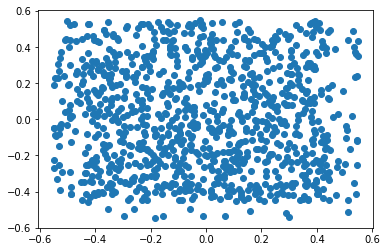

step: 50 	 loss: 2591672 	 hitrate_tr: 0.0207 	 hitrate_test: 0.0177
step: 100 	 loss: 2549708 	 hitrate_tr: 0.0250 	 hitrate_test: 0.0230
step: 150 	 loss: 2640203 	 hitrate_tr: 0.0254 	 hitrate_test: 0.0160
step: 200 	 loss: 2537307 	 hitrate_tr: 0.0250 	 hitrate_test: 0.0248


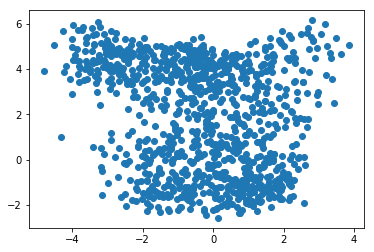

step: 250 	 loss: 2519405 	 hitrate_tr: 0.0326 	 hitrate_test: 0.0195
step: 300 	 loss: 2429047 	 hitrate_tr: 0.0341 	 hitrate_test: 0.0160
step: 350 	 loss: 2355374 	 hitrate_tr: 0.0334 	 hitrate_test: 0.0142
step: 400 	 loss: 2450622 	 hitrate_tr: 0.0358 	 hitrate_test: 0.0177


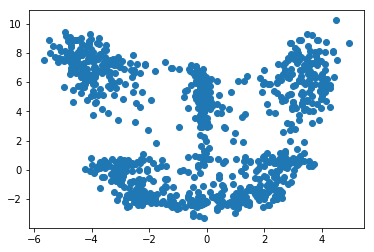

step: 450 	 loss: 2488210 	 hitrate_tr: 0.0345 	 hitrate_test: 0.0213
step: 500 	 loss: 2372778 	 hitrate_tr: 0.0342 	 hitrate_test: 0.0355
step: 550 	 loss: 2321477 	 hitrate_tr: 0.0345 	 hitrate_test: 0.0355
step: 600 	 loss: 2275249 	 hitrate_tr: 0.0367 	 hitrate_test: 0.0266


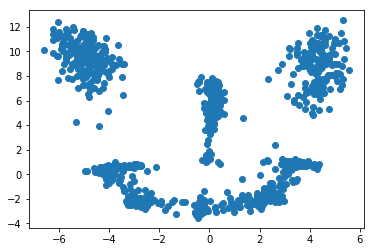

CPU times: user 3min 5s, sys: 5.55 s, total: 3min 10s
Wall time: 3min 6s


In [16]:
%%time
n_steps = 601
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(seqrec.model, seqrec.guide, optimizer, loss=Trace_ELBO())

imgs = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(dat_seq['train'])

    if step%50== 0:
        # RMSE
        hitrate_train = compute_hitrate(dat_seq['train_small'], k = 10)
        hitrate_test = compute_hitrate(dat_seq['test'].sequences, k = 10)

        print(f"step: {step} \t loss: {loss:.0f} \t hitrate_tr: {hitrate_train:.4f} \t hitrate_test: {hitrate_test:.4f}") # \t test-rmse: {rmse_test:.2f}
    if step%200==0:
        V = pyro.param("Vpar").detach().cpu().numpy()
        img = plt.plot(V[:,0], V[:,1], "o", animated=True)
        imgs.append(img[0])
        plt.show()
        

step: 0 	 loss: 2939851 	 hitrate_tr: 0.0113 	 hitrate_test: 0.0142


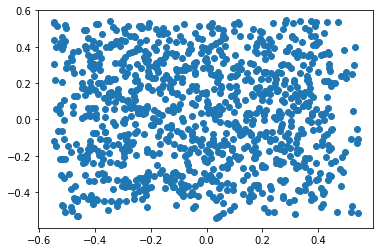

step: 50 	 loss: 2629770 	 hitrate_tr: 0.0199 	 hitrate_test: 0.0142
step: 100 	 loss: 2700401 	 hitrate_tr: 0.0184 	 hitrate_test: 0.0124


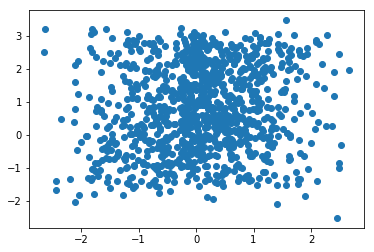

step: 150 	 loss: 2594363 	 hitrate_tr: 0.0205 	 hitrate_test: 0.0142
step: 200 	 loss: 2574329 	 hitrate_tr: 0.0254 	 hitrate_test: 0.0284


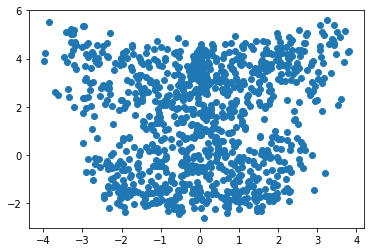

step: 250 	 loss: 2563159 	 hitrate_tr: 0.0308 	 hitrate_test: 0.0177
step: 300 	 loss: 2420316 	 hitrate_tr: 0.0255 	 hitrate_test: 0.0089


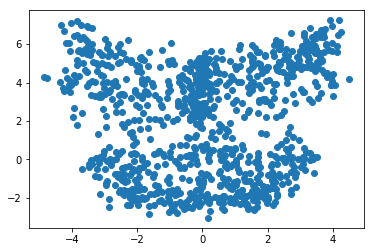

step: 350 	 loss: 2444681 	 hitrate_tr: 0.0317 	 hitrate_test: 0.0124
step: 400 	 loss: 2481395 	 hitrate_tr: 0.0349 	 hitrate_test: 0.0230


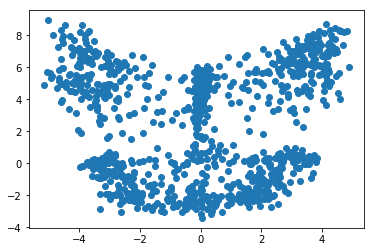

step: 450 	 loss: 2396927 	 hitrate_tr: 0.0304 	 hitrate_test: 0.0106
step: 500 	 loss: 2356648 	 hitrate_tr: 0.0333 	 hitrate_test: 0.0213


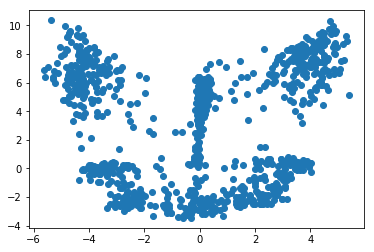

step: 550 	 loss: 2392545 	 hitrate_tr: 0.0337 	 hitrate_test: 0.0284
step: 600 	 loss: 2224381 	 hitrate_tr: 0.0298 	 hitrate_test: 0.0124


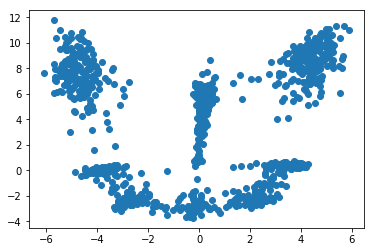

step: 650 	 loss: 2291482 	 hitrate_tr: 0.0277 	 hitrate_test: 0.0106
step: 700 	 loss: 2264973 	 hitrate_tr: 0.0299 	 hitrate_test: 0.0142


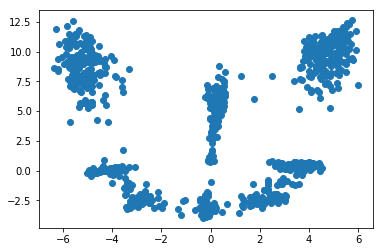

CPU times: user 3min 31s, sys: 4.76 s, total: 3min 35s
Wall time: 3min 32s


In [20]:
%%time
n_steps = 701
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(seqrec.model, seqrec.guide, optimizer, loss=Trace_ELBO())

imgs = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(dat_seq['train'])

    if step%50== 0:
        # RMSE
        hitrate_train = compute_hitrate(dat_seq['train_small'], k = 10)
        hitrate_test = compute_hitrate(dat_seq['test'].sequences, k = 10)

        print(f"step: {step} \t loss: {loss:.0f} \t hitrate_tr: {hitrate_train:.4f} \t hitrate_test: {hitrate_test:.4f}") # \t test-rmse: {rmse_test:.2f}
    if step%100==0:
        V = pyro.param("Vpar").detach().cpu().numpy()
        img = plt.plot(V[:,0], V[:,1], "o", animated=True)
        imgs.append(img[0])
        plt.show()
        

Random items:


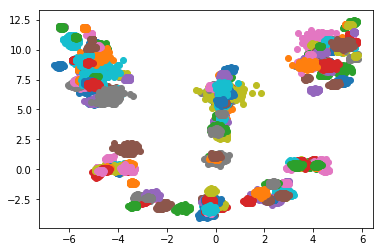

Most and least certain item:


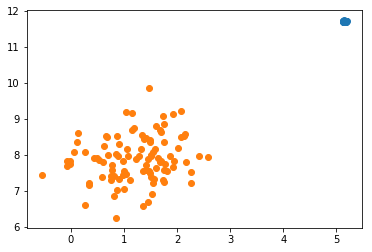

In [21]:
def plot_distr_of_items(u):
    u_means = pyro.param("Vpar")[u,]
    emb_dim = pyro.param("Vpar")[u,].size()[1]
    global_triZ = pyro.param("triangVpar")
    user_var = pyro.param("item_var_factor")[u]

    D_Z = torch.diag(torch.ones(emb_dim).to(device)).unsqueeze(0).repeat(len(user_var),1,1)*user_var.unsqueeze(1).unsqueeze(1)
    triZ = global_triZ.matmul(D_Z)
    user_distr = torch.distributions.MultivariateNormal(u_means, scale_tril=triZ)

    samples = user_distr.sample(torch.tensor([100])).cpu().numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

print("Random items:")
u = torch.randint(low=1, high=len(ind2val['itemId']), size = (300,))
plot_distr_of_items(u)
plt.show()

u = np.array([pyro.param("item_var_factor").argmin().item(), pyro.param("item_var_factor").argmax().item()])
print("Most and least certain item:")
plot_distr_of_items(u)